# SPATIAL ANALYSIS OF ISS DATASETS

This tutorial is an example of how to use Squidpy to analyze In Situ Sequencing datasets, performing several different statistical tests to understand the spatial organization of tissues. This tutorial follows the scanpy tutorial/pciseq tutorials, so we'll take as an input an h5 object created. More information, if needed, can be found at: https://squidpy.readthedocs.io/en/stable/tutorials.html

# Loading the needed packages

The first step is to load the needed packages. If any of them fails, please go and check that they are installed in the appropiate environment

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import squidpy as sq
import scanpy as sc
import os

# Load your dataset

We are going to load our dataset, were we have alredy performed clustering, from an h5ad file. If you want to check how to format your data in this format, please check the Scanpy tutorial

In [46]:
path='/mnt/f/SCRINSHOT/annotated_for_niche_identification/'
files=os.listdir(path)
alls=[]
for f in files:
    print(f)
    tab=pd.read_excel(path+f)
    tab['donor']=f.split('-')[0]
    tab['reg']=f.split('-')[1]
    tab['sample']=tab['donor']+'_'+tab['reg']
    tab.columns=[t.lower().replace(' ','') for t in tab.columns]
    tab=tab.reset_index()
   # tab.columns=refcol
    print(tab.shape)
    alls.append(tab)

583-LNG2-paper-clusters.xlsx
(24691, 14)
583-LNG3-paper-clusters.xlsx
(4504, 14)
583-LNG5-paper-cell-types.xlsx
(51996, 14)
640-LNG2-paper-cell-types.xlsx
(20997, 16)
640-LNG3-paper-cell-types.xlsx
(21649, 15)
640-LNG5-paper-cell-types.xlsx
(34003, 14)


In [124]:
allcells['celltype'].unique()

array(['Suprabasal', 'Basal', 'Immune other', 'Epithelial other',
       'Secretory club', 'Secretory mucous (goblet)', 'Deuterosomal',
       'Endothelial', nan, 'Ciliated', 'Fibroblasts',
       'Suprabasal intermediate', 'SMG Serous', 'SMG intermediate (duct)',
       'Macrophages', 'T lymphocytes', 'Smooth Muscle', 'Mast',
       'Neuroendocrine', 'Mesenchyme other', 'Myoepithelial', 'Neuronal',
       'SMG mucous', 'Alveolar type 0', 'Secretory pre-TB',
       'Secretory TRB', 'Alveolar type II', 'Alveolar type I',
       'Monocytes', 'NK cells', 'SMG serous'], dtype=object)

In [47]:
allcells=pd.concat(alls)

In [126]:
pat='/mnt/f/COPD/'
smp=pd.read_excel(pat+'COPD-clusters-final-upd.xlsx')


In [129]:
smp.columns=[col.lower().replace(' ','') for col in smp.columns]

In [130]:
allcells['experiment']='atlas'
smp['experiment']='biopsies'

In [62]:
di={'Smooth muscle':'Smooth Muscle','Epithelial other':'Epithelial unknown'}
allcells.loc[allcells['celltype']=='Smooth muscle','celltype']='Smooth Muscle'

In [63]:
allall=pd.concat([smp,allcells])

In [65]:
# cell types in the atlas, but not in biopsies
common=[c for c in  allcells['celltype'].unique() if c in smp['celltype'].unique()]

In [71]:
l2=[ 'SMG Serous', 'SMG intermediate (duct)', 'Smooth muscle', 'Myoepithelial', 'SMG mucous', 'SMG serous']
allall2=allall.loc[allall['celltype'].isin(common+l2),:]

In [72]:
adata=sc.AnnData(obs=allall2)

/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [73]:
adata.obsm["spatial"]=np.array([adata.obs.x,adata.obs.y,adata.obs.y]).transpose().astype('float64')

In [74]:
#adata.obs.to_csv('/mnt/c/Users/sergio.salas/Documents/PhD/projects/DIPG/UMPED65_A2_2_celltypes.csv')

In [75]:
adata

AnnData object with n_obs × n_vars = 178062 × 0
    obs: 'unnamed:0', 'number', 'donor', 'sample', 'disease', 'smoking', 'gender', 'roi', 'area', 'x', 'y', 'clusters-pc7', 'cellclass', 'celltype', 'cellsubtype', 'experiment', 'index', 'cell', 'reg', 'x1', 'y1', 'cellsubype', 'region'
    obsm: 'spatial'

In [ ]:
for samp in adata.obs['sample'].unique():
    asub=adata[adata.obs['sample']==samp]
    print(samp)
    plt.figure(figsize=(50,50))
    sc.pl.spatial(
    asub,
    color="celltype",
    neighbors_key="spatial_neighbors",
    spot_size=70,
    edges=False,
    edges_width=2,
    img_key=None,
    )

# NEIGHBORHOOD PLOTS

In [76]:
adata.obs['name']=adata.obs['celltype']
ad=adata

In [77]:
anndata_list = []
for sample in ad.obs['sample'].unique():
    adata_copy_int = ad[ad.obs['sample'] == sample ]
    #    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])
    sq.gr.spatial_neighbors(adata_copy_int,n_neighs=15)
    result=np.zeros([adata_copy_int.shape[0],len(adata_copy_int.obs['name'].unique())])
    n=0
    tr=adata_copy_int.obsp['spatial_distances'].transpose()
    tr2=tr>0
    from tqdm import tqdm
    for g in tqdm(adata_copy_int.obs['name'].unique()):
        epv=adata_copy_int.obs['name']==g*1
        opv=list(epv*1)
        result[:,n]=tr2.dot(opv)
        n=n+1
    expmat=pd.DataFrame(result,columns=adata_copy_int.obs['name'].unique())
    adata1=sc.AnnData(expmat,obs=adata_copy_int.obs)
    adata1.obs['sample']=sample
    adata1.obs['total_counts']=list(np.sum(expmat,axis=1))
    anndata_list.append(adata1)
ad_sp_concat = sc.concat(anndata_list, pairwise=True,join='outer')

/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 453.63it/s]
/tmp/ipykernel_266/3145624594.py:17: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata1=sc.AnnData(expmat,obs=adata_copy_int.obs)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transformin

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 492.48it/s]
/tmp/ipykernel_266/3145624594.py:17: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata1=sc.AnnData(expmat,obs=adata_copy_int.obs)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1189.62it/s]

In [79]:
'''
anndata_list = []
for sample in ad.obs['sample'].unique():
    adata_copy_int = ad[ad.obs['sample'] == sample ]
###    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])
    sq.gr.spatial_neighbors(adata_copy_int,radius=250.0,coord_type='generic')
    arrs=((adata_copy_int.obsp['spatial_distances']>0).toarray())*1
    datf=pd.DataFrame(arrs)
    datf['key']=list(adata_copy_int.obs['name'])
    neighmatrix=datf.groupby('key').sum().transpose()
    adataneigh=sc.AnnData(neighmatrix)
    adataneigh.obs=adata_copy_int.obs
    adataneigh.obs['counts']=list(np.sum(neighmatrix,axis=1))
    anndata_list.append(adataneigh)
ad_sp_concat = sc.concat(anndata_list, pairwise=True,join='outer')
'''

"\nanndata_list = []\nfor sample in ad.obs['sample'].unique():\n    adata_copy_int = ad[ad.obs['sample'] == sample ]\n###    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])\n    sq.gr.spatial_neighbors(adata_copy_int,radius=250.0,coord_type='generic')\n    arrs=((adata_copy_int.obsp['spatial_distances']>0).toarray())*1\n    datf=pd.DataFrame(arrs)\n    datf['key']=list(adata_copy_int.obs['name'])\n    neighmatrix=datf.groupby('key').sum().transpose()\n    adataneigh=sc.AnnData(neighmatrix)\n    adataneigh.obs=adata_copy_int.obs\n    adataneigh.obs['counts']=list(np.sum(neighmatrix,axis=1))\n    anndata_list.append(adataneigh)\nad_sp_concat = sc.concat(anndata_list, pairwise=True,join='outer')\n"

In [80]:
adataneigh=ad_sp_concat#[:,ad_sp_concat.var.index.isin(['MES_like','Cycling','OPC_like','AC_like','OC_like'])]
adataneigh.obsm["spatial"]=np.array([adataneigh.obs.x,adataneigh.obs.y]).transpose().astype('float64')
adataneigh.X=np.nan_to_num(adataneigh.X)
#adataneigh=adataneigh[adataneigh.obs['total_counts']>5]
#adataneigh=adataneigh[adataneigh.obs['counts']<80]

In [81]:
sc.pp.filter_cells(adataneigh,min_genes=2)

/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [82]:
adataneigh

AnnData object with n_obs × n_vars = 174777 × 23
    obs: 'unnamed:0', 'number', 'donor', 'sample', 'disease', 'smoking', 'gender', 'roi', 'area', 'x', 'y', 'clusters-pc7', 'cellclass', 'celltype', 'cellsubtype', 'experiment', 'index', 'cell', 'reg', 'x1', 'y1', 'cellsubype', 'region', 'name', 'total_counts', 'n_genes'
    obsm: 'spatial'

In [83]:
adataneigh.raw=adataneigh
#sc.pp.log1p(adataneigh)
#sc.pp.normalize_total(adataneigh, target_sum=1e4)


In [84]:
sc.pp.neighbors(adataneigh, n_neighbors=15)
#sc.tl.umap(adataneigh,min_dist=0.1)
sc.set_figure_params(scanpy=True, dpi=200)

/home/sergioms/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sergioms/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sergioms/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

In [85]:
sc.tl.umap(adataneigh,min_dist=0.1,spread=2.0)

In [86]:
sc.tl.leiden(adataneigh,resolution=0.4,key_added='clusters')

In [28]:
tab=adataneigh.obs.groupby('clusters').count()
adataneigh=adataneigh[adataneigh.obs['clusters'].isin(tab.loc[tab.loc[:,'cell']>40].index)]
adataneigh.var.index=adataneigh.var.index.astype(str)

In [ ]:
#sc.rcParams['plt.facecolor'] = 'white'
sc.pl.umap(adataneigh,color=['clusters','sample','reg','celltype','experiment'],s=10,ncols=1)#,save='UMAP_10X_colors.svg')

In [ ]:
sc.pl.umap(adataneigh,color='disease')

In [ ]:
for c in adataneigh.to_df().columns:
    sc.pl.umap(adataneigh,color=c)

In [ ]:
sc.pl.umap(adata)

In [95]:
adataneigh=adataneigh[adataneigh.obs['clusters'].astype(int)<14]

In [ ]:
plt.rcParams['plt.facecolor'] = 'white'
sc.pl.umap(adataneigh,color=['clusters'],s=10)#,save='UMAP_10X_colors.svg')

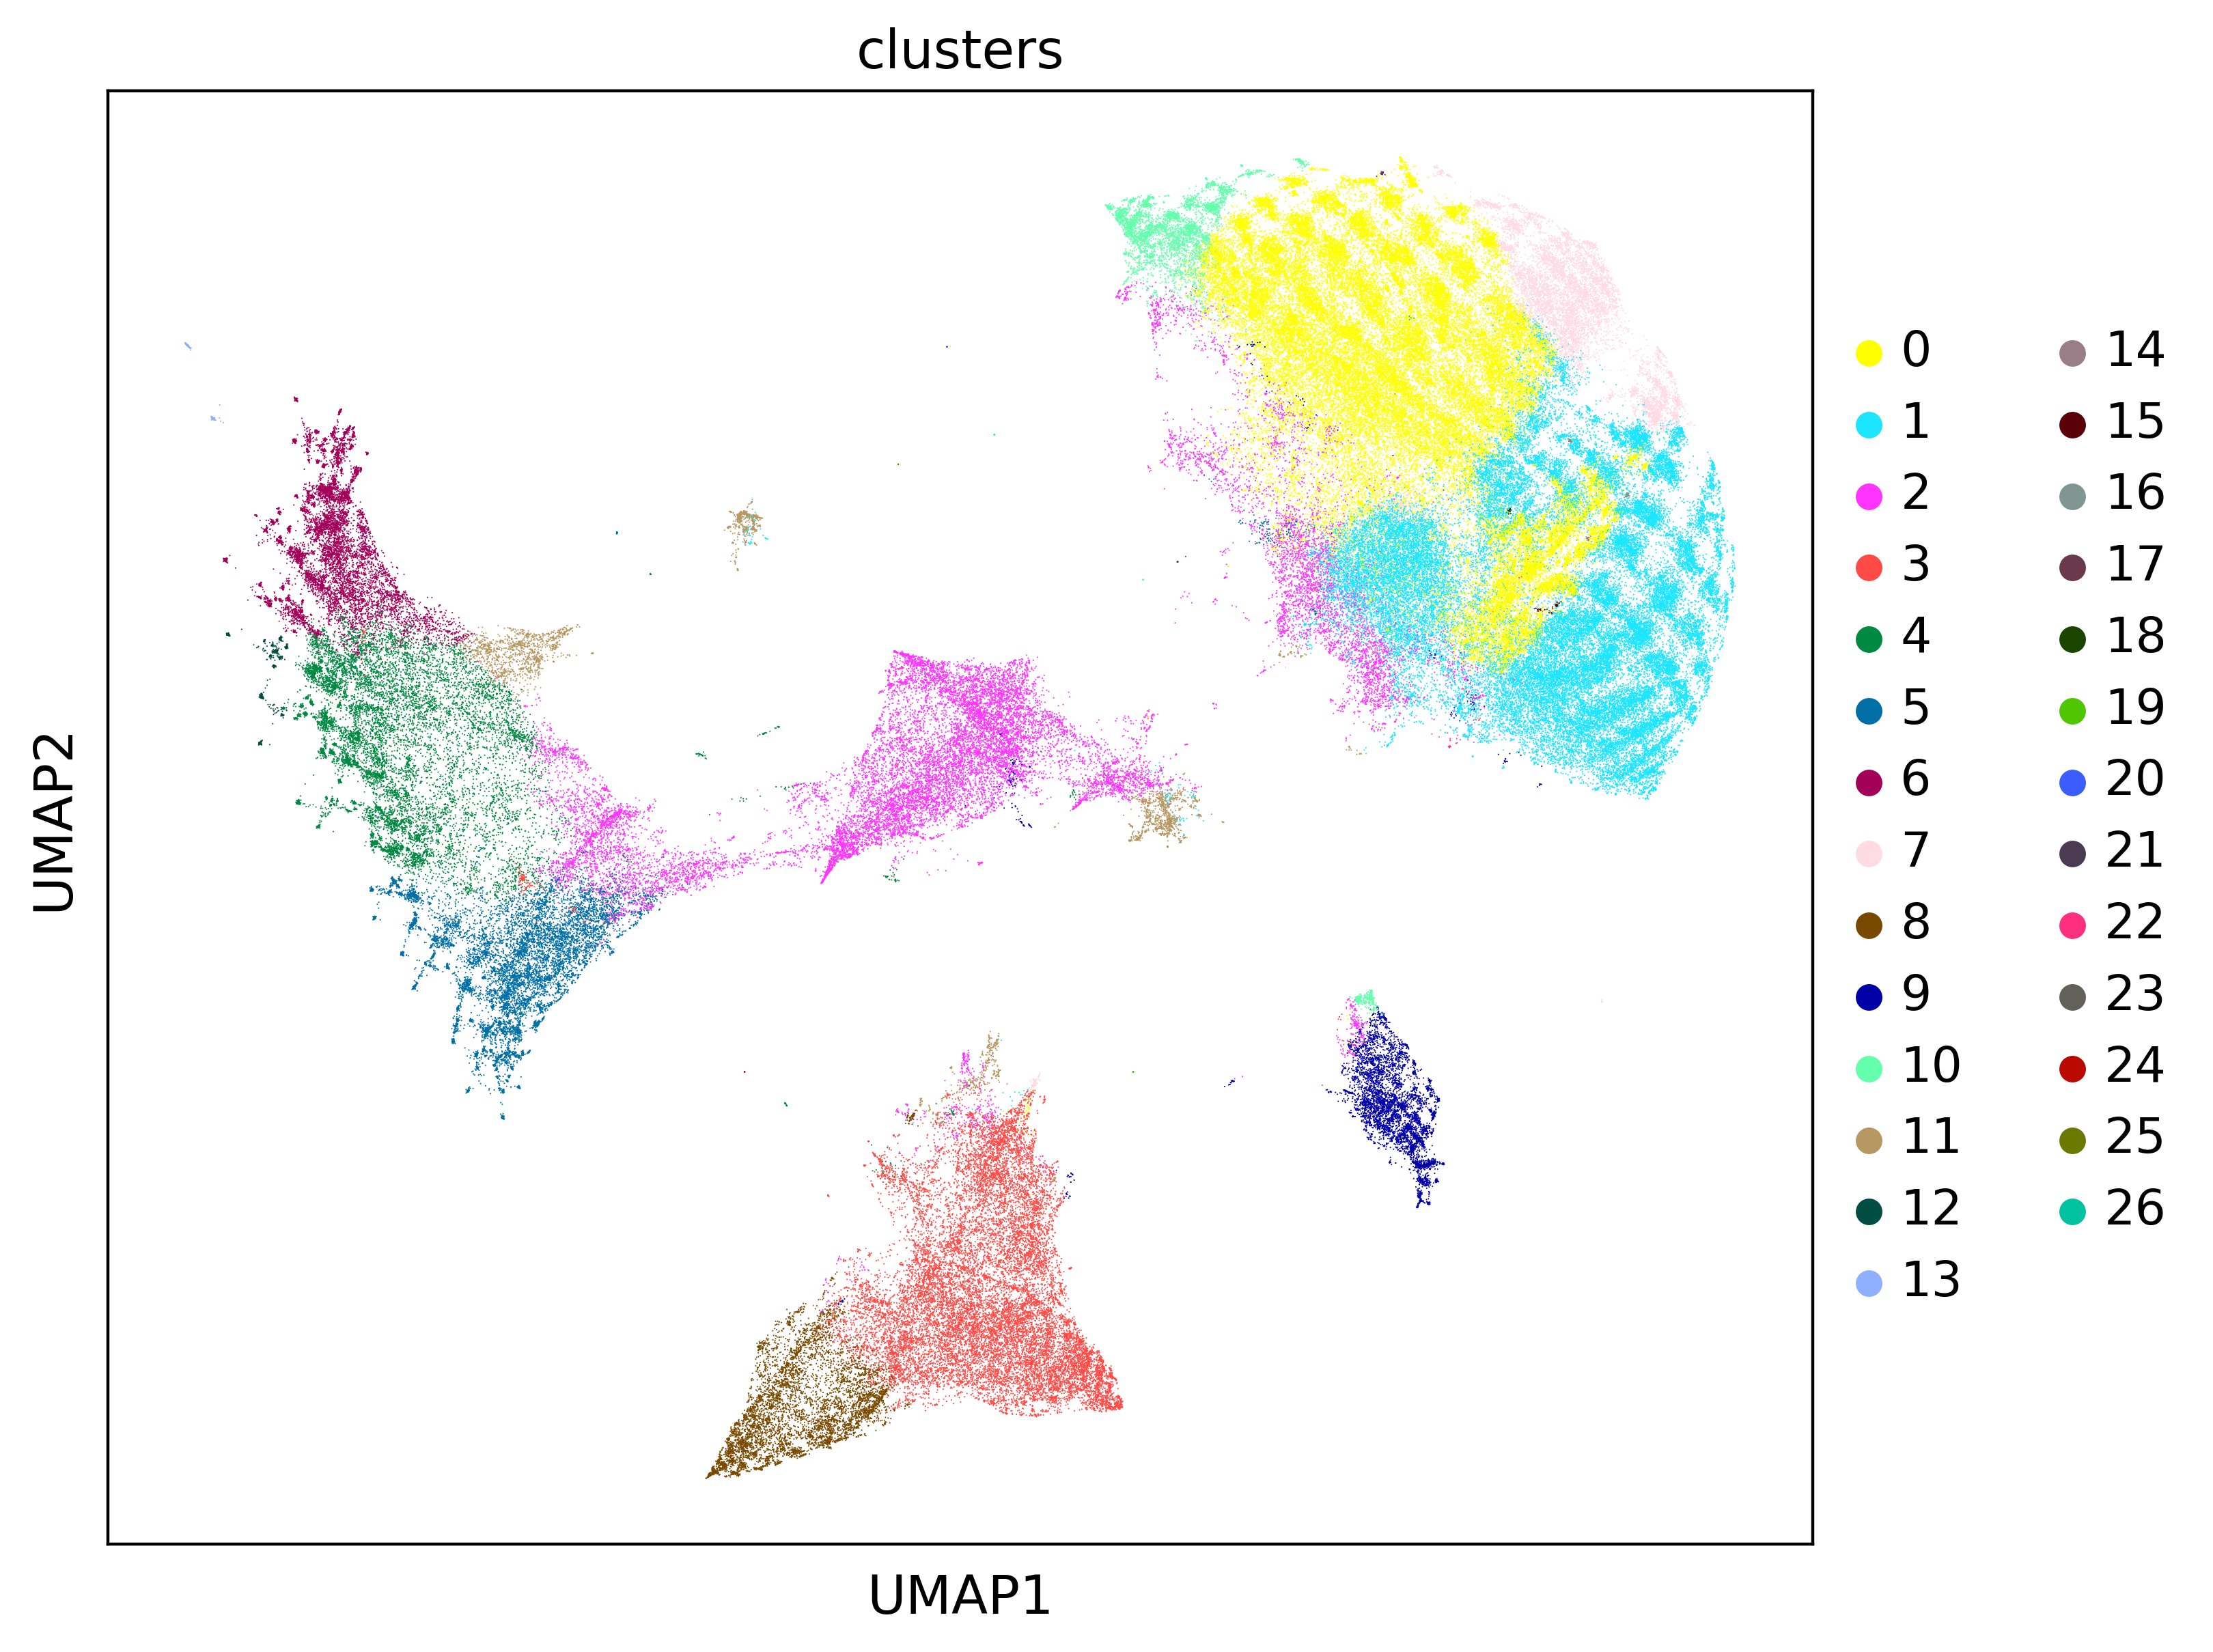

In [75]:
#plt.rcParams['plt.facecolor'] = 'white'
sc.pl.umap(adataneigh,color=['clusters'])#,save='UMAP_10X_colors.svg')

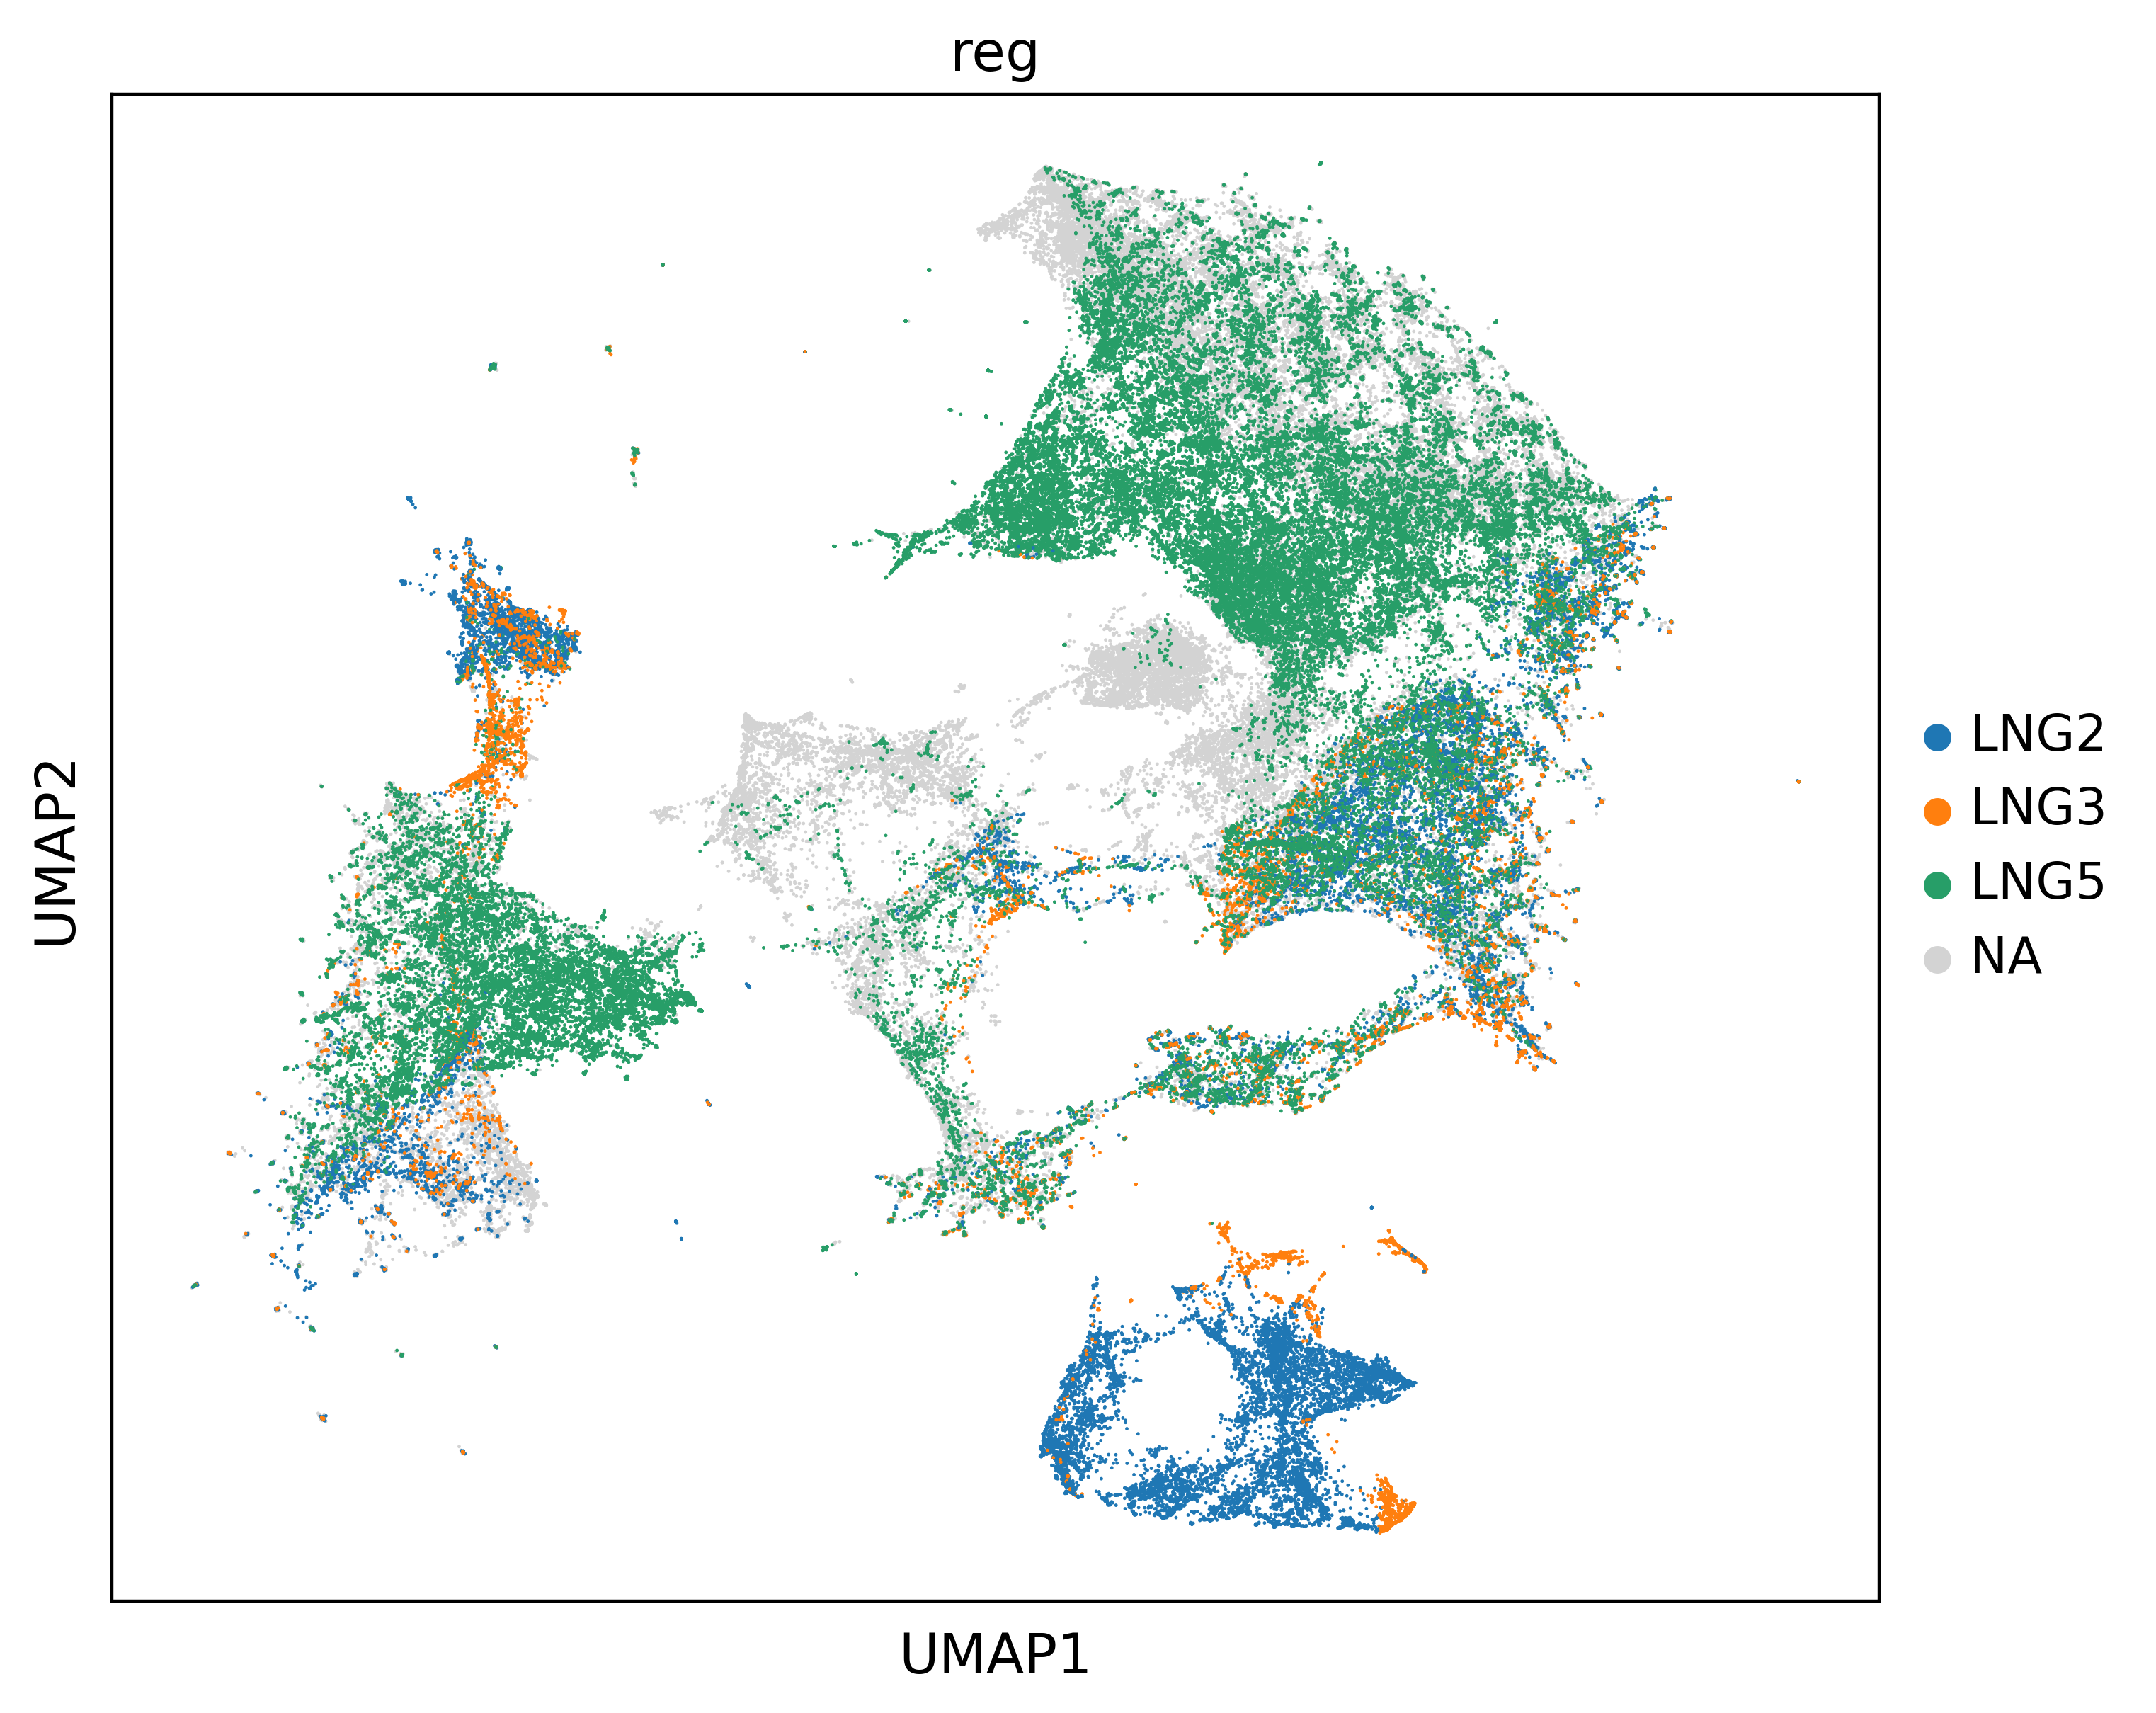

In [99]:
#plt.rcParams['plt.facecolor'] = 'white'
sc.pl.umap(adataneigh,color=['reg'],s=3)#,save='UMAP_10X_colors.svg')

In [61]:
dic=pd.read_csv('/mnt/d/ISS/annotations_dicts/colors_celltype_annotated_general.csv',sep=';')
dictio=dict(zip(dic['celltype_annotated_general'],dic['color']))

In [62]:
adataneigh.uns['celltype_annotated_general_colors']=[dictio[s] for s in  np.unique(adataneigh.obs['celltype_annotated_general'])]

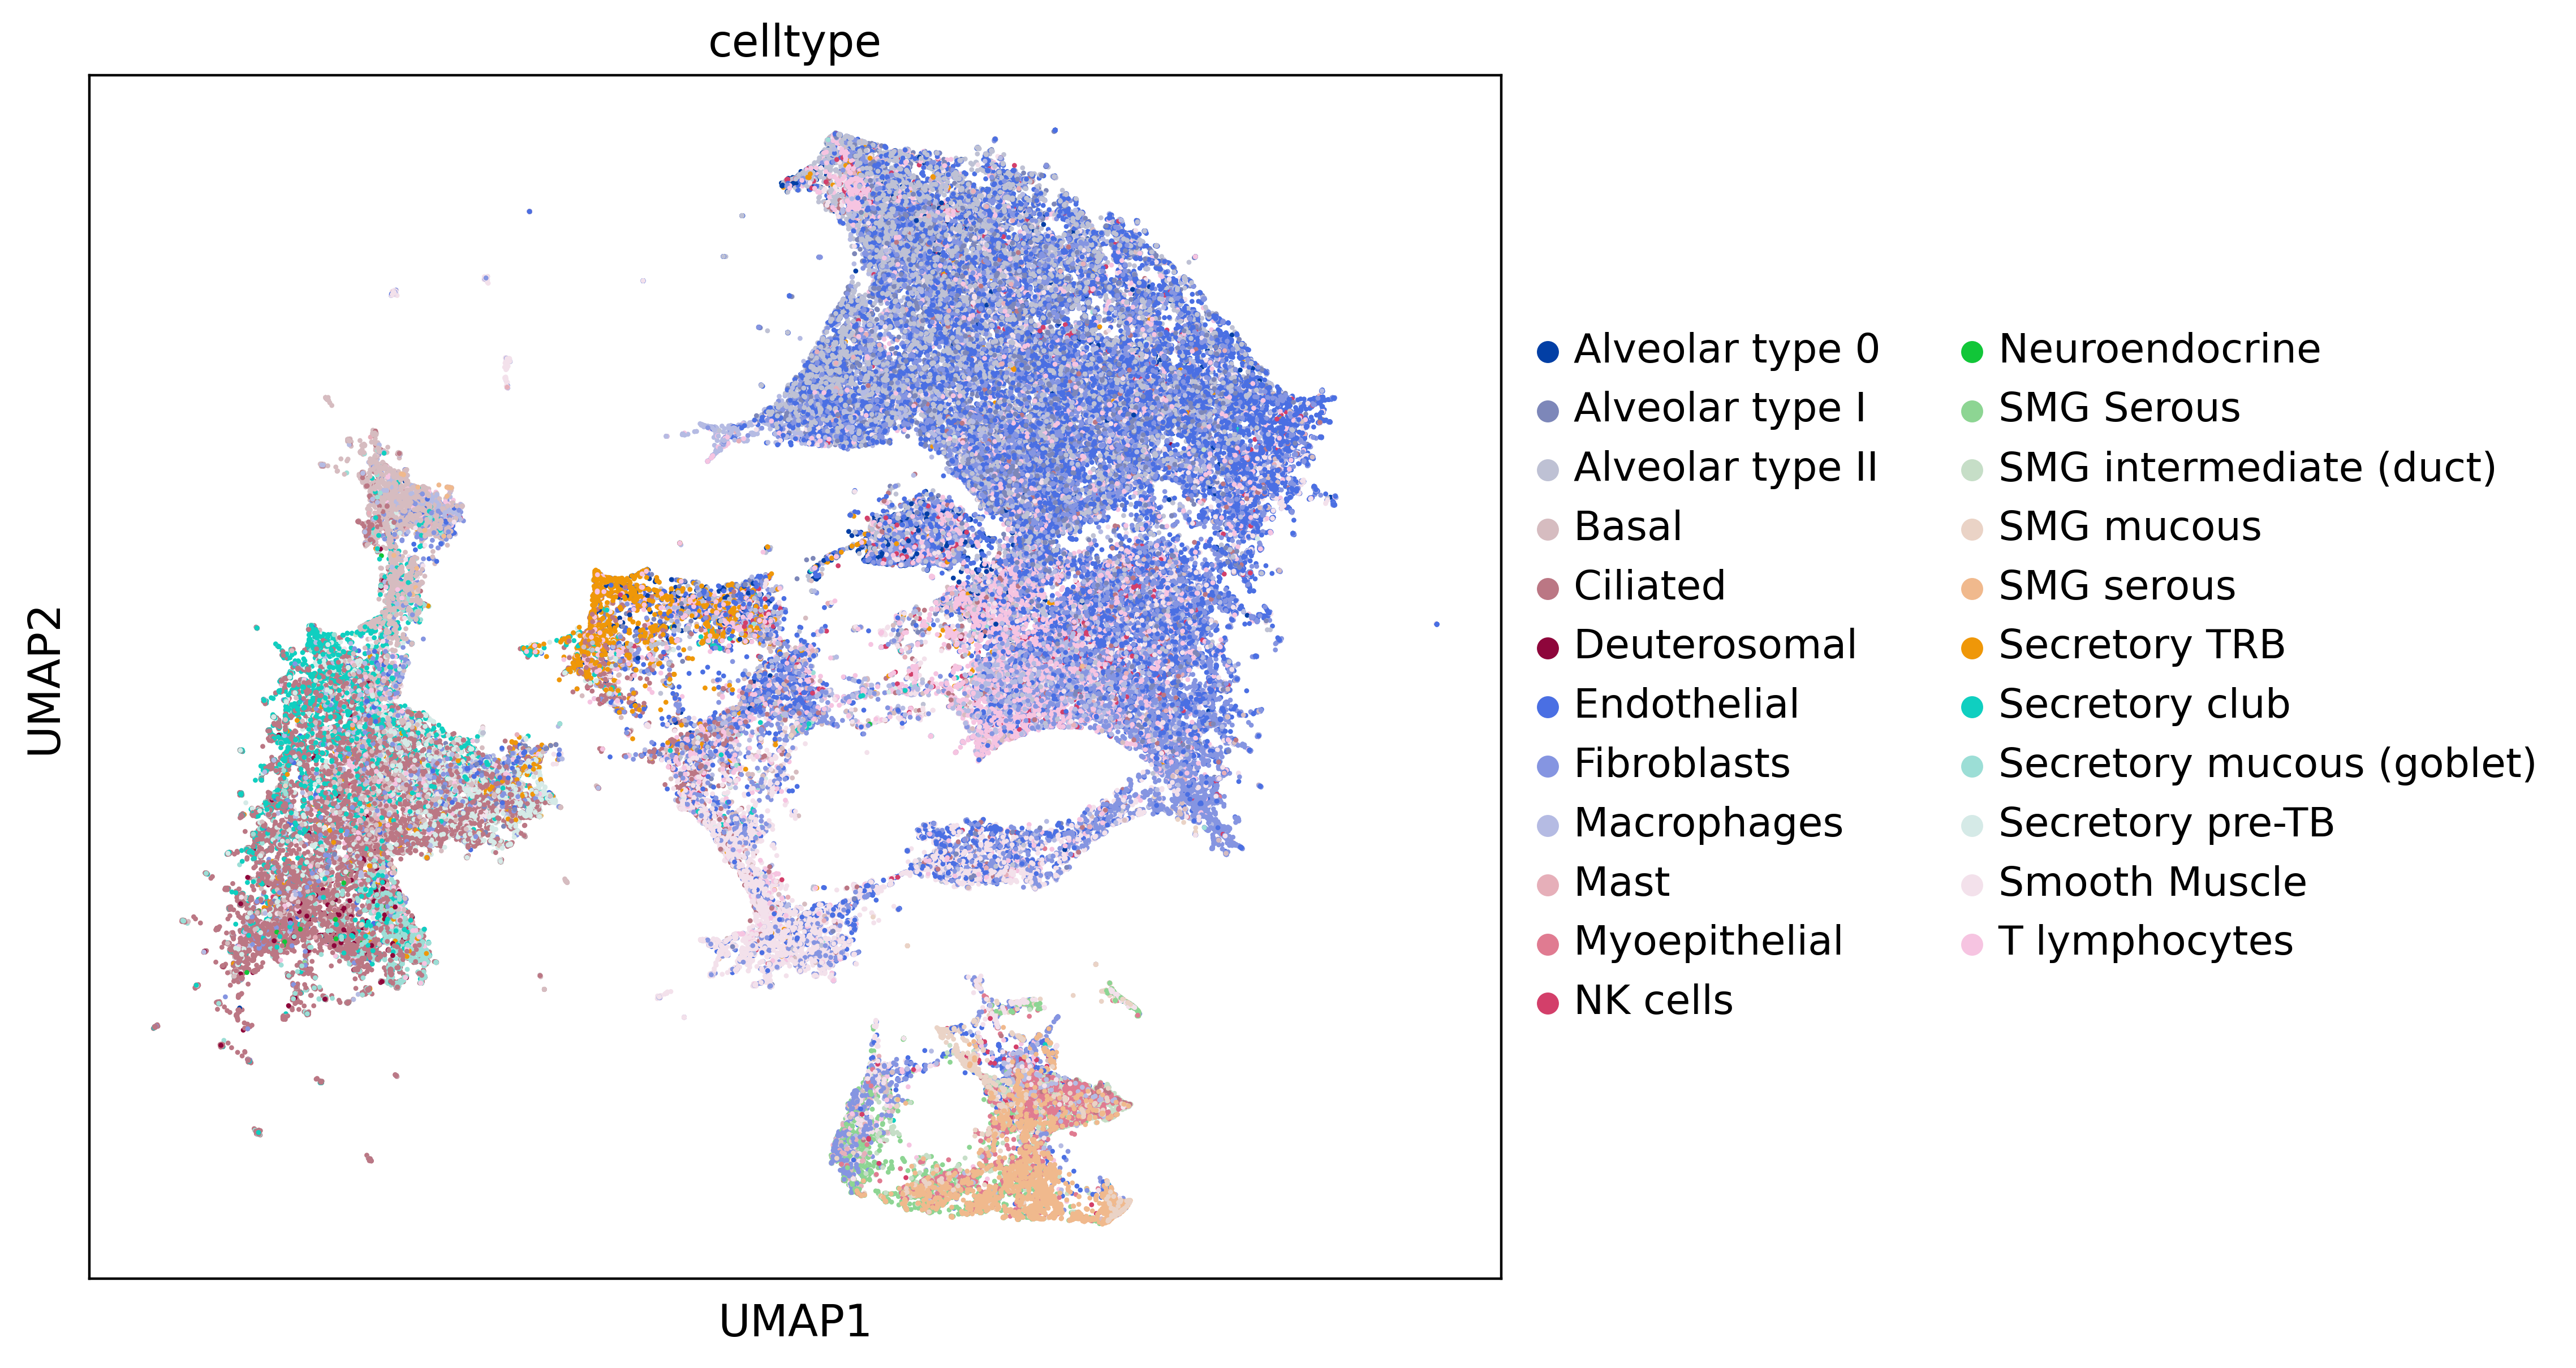

In [96]:
#plt.rcParams['plt.facecolor'] = 'white'
sc.set_figure_params(figsize=(8,7),dpi=200)
sc.pl.umap(adataneigh,color=['celltype'],s=10)#,save='UMAP_10X_colors.svg')

In [ ]:
#plt.rcParams['plt.facecolor'] = 'white'
sc.pl.umap(adataneigh,color=adataneigh.var.index,vmax='p99')#,save='UMAP_10X_colors.svg')

In [102]:
adataneigh.write('/mnt/f/COPD/niches_analysis_COPD_SCRINSHOT.h5ad')

In [66]:
import scanpy as sc
adataneigh=sc.read('/mnt/f/COPD/niches_analysis_COPD_SCRINSHOT.h5ad')

/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [103]:
adataneigh

AnnData object with n_obs × n_vars = 174777 × 23
    obs: 'unnamed:0', 'number', 'donor', 'sample', 'disease', 'smoking', 'gender', 'roi', 'area', 'x', 'y', 'clusters-pc7', 'cellclass', 'celltype', 'cellsubtype', 'experiment', 'index', 'cell', 'reg', 'x1', 'y1', 'cellsubype', 'region', 'name', 'total_counts', 'n_genes', 'clusters'
    uns: 'neighbors', 'umap', 'leiden', 'clusters_colors', 'sample_colors', 'reg_colors', 'celltype_colors', 'experiment_colors', 'disease_colors', 'donor_colors', 'smoking_colors', 'gender_colors', 'region_colors'
    obsm: 'spatial', 'X_umap'
    obsp: 'distances', 'connectivities'

In [68]:
#adataneigh.var.index=adataneigh.var.index+'_neighbors'

In [104]:
def map_of_clusters(adata,key='leiden',clusters='all',size=8,background='white',figuresize=(10,7),save=None,format='pdf'):
    
    #PARAMETERS TO MODIFY:
    #-key: the terms in adata.obs that you want to plot
    #-clusters:'all' for plotting all clusters in a single plot, 'individual': for plots of individual genes, or ['3','5'] (your groups
    #          between square brackets to plot only some clusters
    #-size: to change the size of your spots
    #-background: to change the color of the background
    #-figuresize: to specify the size of your figure
    #-save: if you want to save your figure, give the PATH of the folder where you want to save it
    #-format: specify the format in which you want to save your figure
    
    try:
        adata.obs[key]=adata.obs[key].astype(int)
        colors=dict(zip(np.unique(adata.obs[key]),adata.uns[key+'_colors']))
    except:
        colors=dict(zip(np.unique(adata.obs[key]),adata.uns[key+'_colors']))
    #cl.apply(lambda x: colors[x])
    plt.rcParams['figure.facecolor'] = background
    if clusters=='all':
        cl=adata.obs[key]
        plt.figure(figsize=figuresize)
        figa=plt.scatter(x=adata.obs.X,y=adata.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)
        plt.axis('off')
        if not save==None:
            plt.savefig(save +'/map_all_clusters_'+str(size)+'_'+background+'_'+key+'.'+format)
    elif clusters=='individual':
        cl=adata.obs[key]
        for each in adata.obs[key].unique():
            adatasub=adata[adata.obs[key]==each]
            plt.figure(figsize=figuresize)
            plt.scatter(x=adata.obs.X,y=adata.obs.Y,c='grey',s=size/5,linewidths=0, edgecolors=None)
            cl=adatasub.obs[key]
            plt.scatter(x=adatasub.obs.X,y=adatasub.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)
            plt.axis('off')
            plt.title('Group: '+ str(each))
            if not save==None:
                plt.savefig(save +'/map_inidivdual_cluster_'+str(each)+'_'+str(size)+background+'_'+key+'.'+format)
    else:
        adatasub=adata[adata.obs[key].isin(clusters)]
        plt.figure(figsize=figuresize)
        plt.scatter(x=adata.obs.X,y=adata.obs.Y,c='grey',s=size/5,linewidths=0, edgecolors=None)
        cl=adatasub.obs[key]
        plt.scatter(x=adatasub.obs.X,y=adatasub.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)
        plt.axis('off')
        plt.legend()
        if not save==None:
                s=''
                for element in clusters:
                    s=s+str(element)
                print(s)
                plt.savefig(save +'/map_group_of_clusters_'+str(s)+'_'+str(size)+background+'_'+key+'.'+format)
#        plt.title('Group: '+ paste(clusters))

In [105]:
adataneigh.obs['X']=adataneigh.obs['x']
adataneigh.obs['Y']=adataneigh.obs['y']

In [106]:
adataneigh.uns['clusters_colors']

['#ffff00',
 '#1ce6ff',
 '#ff34ff',
 '#ff4a46',
 '#008941',
 '#006fa6',
 '#a30059',
 '#ffdbe5',
 '#7a4900',
 '#0000a6',
 '#63ffac',
 '#b79762',
 '#004d43',
 '#8fb0ff',
 '#997d87',
 '#5a0007',
 '#809693',
 '#6a3a4c',
 '#1b4400',
 '#4fc601',
 '#3b5dff',
 '#4a3b53',
 '#ff2f80',
 '#61615a',
 '#ba0900',
 '#6b7900',
 '#00c2a0',
 '#ffaa92',
 '#ff90c9',
 '#b903aa',
 '#d16100']

'nan'

'atlasnan'

In [ ]:
key='clusters'
for sam in adataneigh.obs['sample'].unique():
    print(sam)
    adataneigh2=adataneigh[adataneigh.obs['sample']==sam]
    print(adataneigh2.obs['experiment'][0]+'_'+str(adataneigh2.obs['disease'][0]))
    sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor='white', transparent=False, ipython_format='png2x')
    sc.pl.umap(adataneigh2,color=[key])#,save='UMAP_10X_colors.svg')
    map_of_clusters(adataneigh2,key=key,size=6,background='white',figuresize=(7,7))

# plot_by_region

In [151]:
adataneigh.obs['sample_disease']=adataneigh.obs['sample'].astype(str)+'_'+adataneigh.obs['disease'].astype(str)

In [152]:
clust_by_region=pd.crosstab(adataneigh.obs['sample_disease'],adataneigh.obs['clusters'])
clust_by_region=clust_by_region.div(clust_by_region.sum(axis=1),axis=0)

In [155]:
s2dis=dict(zip(adataneigh.obs['sample_disease'],adataneigh.obs['disease'].astype(str)))

In [158]:
cls=clust_by_region.unstack().reset_index()

In [161]:
cls['disease']=cls['sample_disease'].map(s2dis)

In [ ]:
plt.figure(figsize=(5,20))
sns.boxplot(data=cls,y='clusters',x=0,hue='disease')

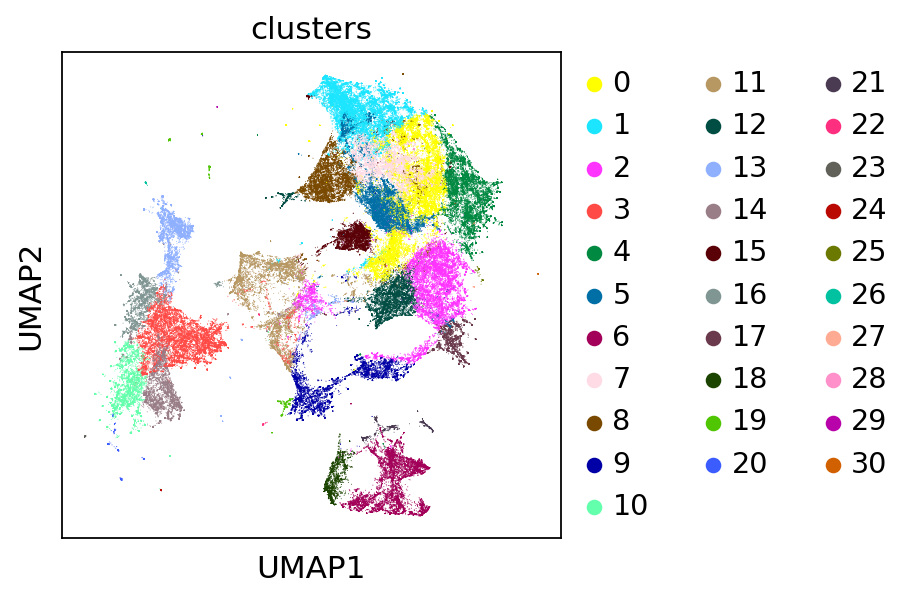

In [168]:
sc.pl.umap(adataneigh,color='clusters')

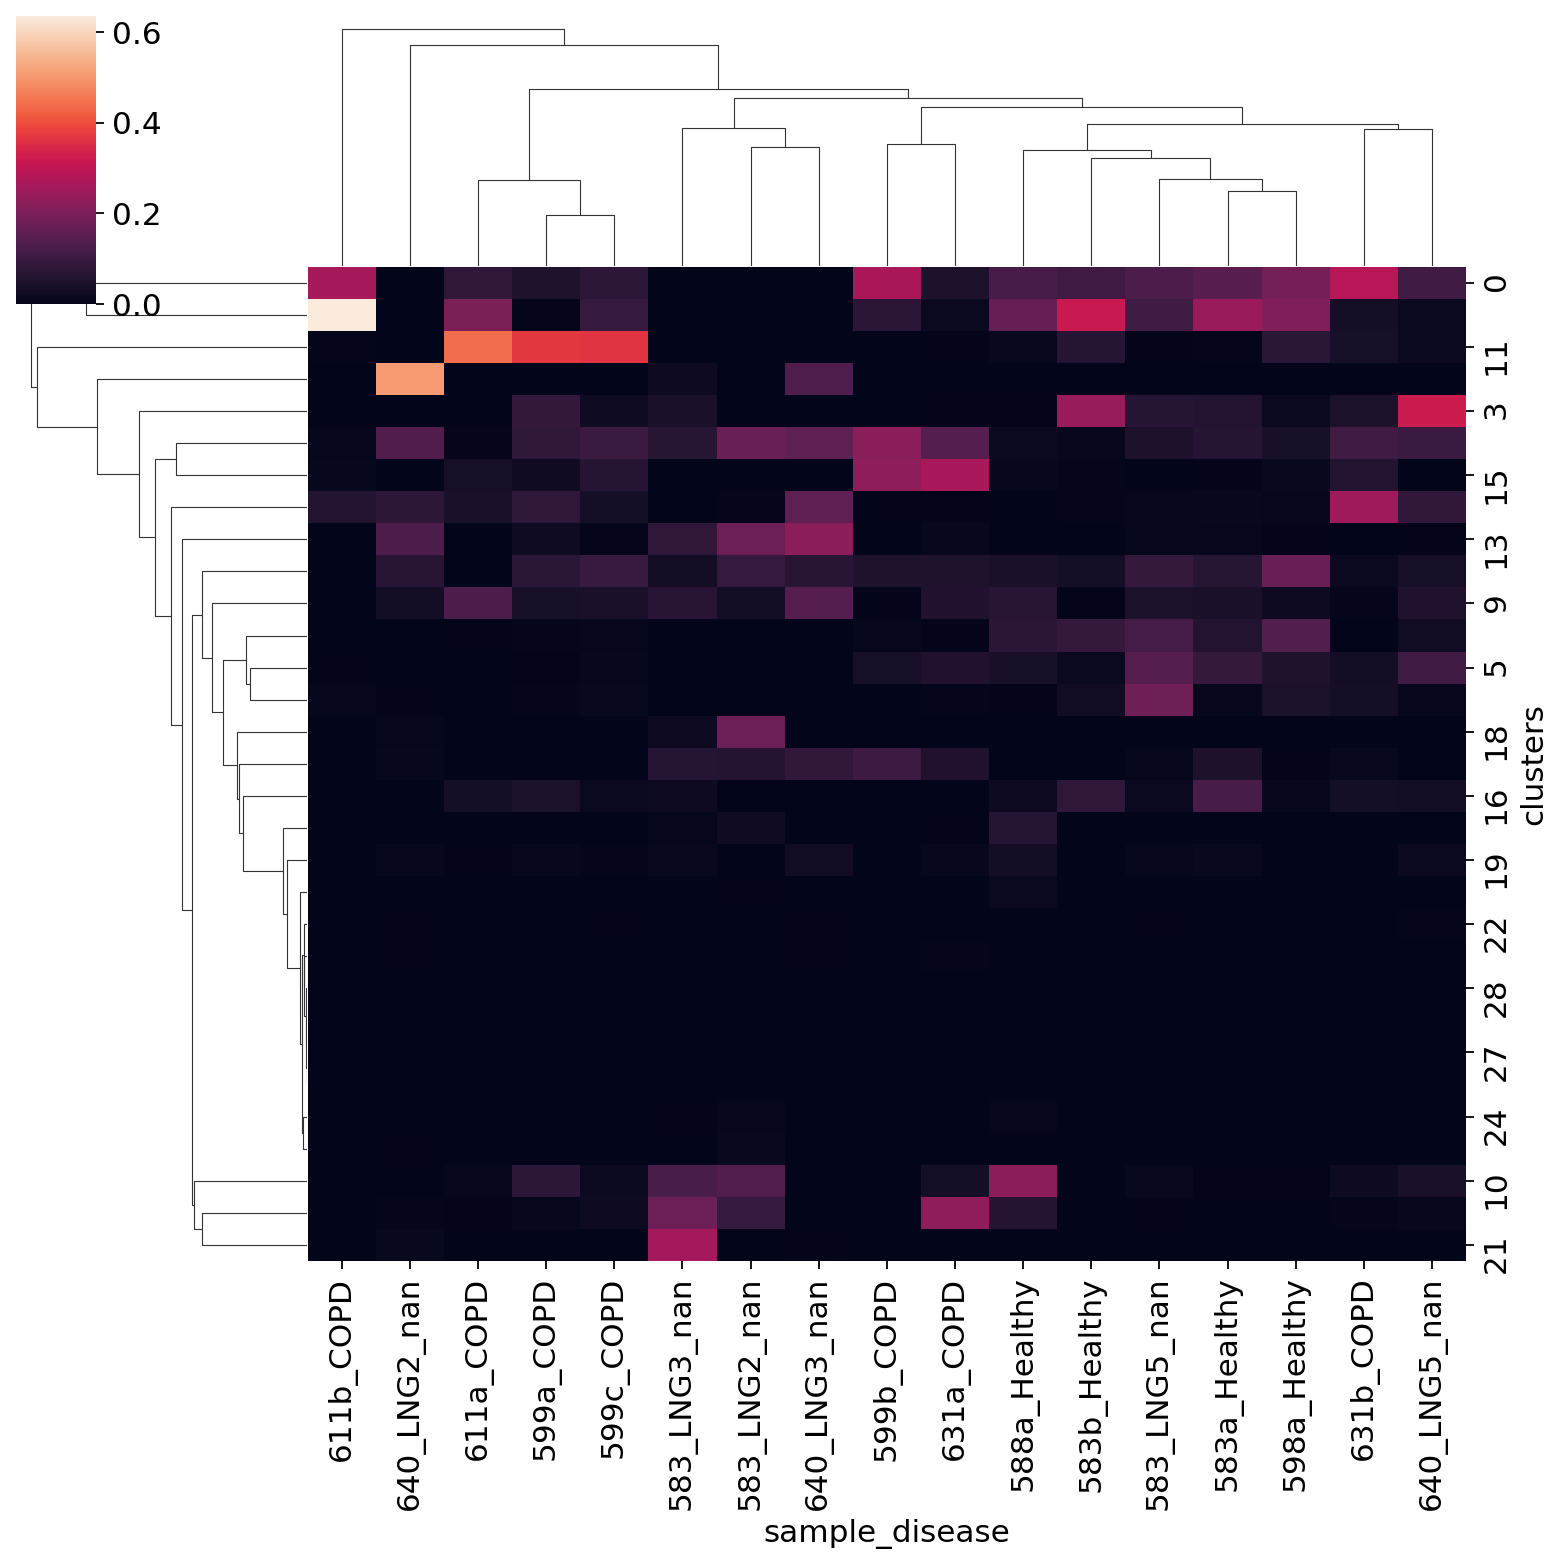

In [154]:
import seaborn as sns
sns.clustermap(clust_by_region.transpose())